In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn import model_selection

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

In [2]:
tripdata = pd.read_csv("../dataset/final_bike_sharing.csv")

In [3]:
tripdata.head(3)

,tripduration,start_lat,start_lon,end_lat,end_lon,usertype,gender,dist,birthyear,date,...,feelslike,precip,dew,humidity,snow,windspeed,visibility,solarradiation,conditions,seasons
0,932,40.716247,-74.033459,40.728745,-74.032108,Subscriber,1,0.9,1992,2018-01-01,...,-17.0,0.0,-19.9,47.8,0.0,18.5,16.0,106.7,Clear,winter
1,550,40.716247,-74.033459,40.728745,-74.032108,Subscriber,2,0.9,1969,2018-01-01,...,-17.0,0.0,-19.9,47.8,0.0,18.5,16.0,106.7,Clear,winter
2,510,40.716247,-74.033459,40.728745,-74.032108,Subscriber,1,0.9,1946,2018-01-01,...,-17.0,0.0,-19.9,47.8,0.0,18.5,16.0,106.7,Clear,winter


### Amputation logic

In [4]:
## get the sample size such as 5%, 10%,20% etc
def get_sample_size(df, perc=5):
    return round(perc/100 * df.shape[0])

def get_an_index(index):
    li = []
    for i in index:
        li.append(i)
    return li  

def convert_to_dataframe(y_train):
    return pd.DataFrame(y_train)

def convert_to_series(y_train):
    return y_train.squeeze()
        
random.seed(100)
def ampute_nan_values(X_train,y_train,col_name, perc):
    index = get_an_index(X_train.index)
    sample_size = get_sample_size(X_train, perc)
    selected_index = random.sample(index, sample_size)
    y_train = convert_to_dataframe(y_train)
    for i in selected_index:
        if col_name in X_train.columns:
            X_train.at[i,col_name]= np.NaN
        else:
            X_train.loc[i] = np.NaN
        y_train.loc[i] = np.NaN
    y_train = convert_to_series(y_train)
    return X_train, y_train

### Split the data into train and test

In [5]:
X = tripdata.drop('tripduration', axis=1)
y = tripdata['tripduration']
print(X.shape)
print(y.shape)

(352767, 28)
(352767,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (282213, 28) (282213,)
Test (70554, 28) (70554,)


### Ampute on Train data

In [7]:
X_train , y_train = ampute_nan_values(X_train,y_train,"birthyear",perc=5)

In [8]:
print('Train after amputation', X_train.shape, y_train.shape)
print(X_train.isnull().sum())

Train after amputation (282213, 28) (282213,)
start_lat             0
start_lon             0
end_lat               0
end_lon               0
usertype              0
gender                0
dist                  0
birthyear         14111
date                  0
month                 0
day                   0
hour                  0
min                   0
year                  0
years_old             0
holiday               0
datetime              0
temp                  0
feelslike             0
precip                0
dew                   0
humidity              0
snow                  0
windspeed             0
visibility            0
solarradiation        0
conditions            0
seasons               0
dtype: int64


In [9]:
print(y_train.isnull().sum())

14111


#### 1. Imputation Remove just remove NA

In [10]:
X_train.dropna(axis=0, inplace=True)
y_train.dropna(inplace=True)

In [11]:
print('Train after Imputation', X_train.shape, y_train.shape)

Train after Imputation (268102, 28) (268102,)


 ### Amputation on Test data

In [12]:
X_test , y_test = ampute_nan_values(X_test,y_test,"birthyear",perc=5)

In [13]:
print('Test after amputation', X_test.shape, y_test.shape)
print(X_test.isnull().sum())

Test after amputation (70554, 28) (70554,)
start_lat            0
start_lon            0
end_lat              0
end_lon              0
usertype             0
gender               0
dist                 0
birthyear         3528
date                 0
month                0
day                  0
hour                 0
min                  0
year                 0
years_old            0
holiday              0
datetime             0
temp                 0
feelslike            0
precip               0
dew                  0
humidity             0
snow                 0
windspeed            0
visibility           0
solarradiation       0
conditions           0
seasons              0
dtype: int64


In [14]:
print(y_test.isnull().sum())

3528


In [15]:
X_test.dropna(axis=0, inplace=True)
y_test.dropna(inplace=True)

In [16]:
print('Train after Imputation', X_test.shape, y_test.shape)

Train after Imputation (67026, 28) (67026,)


### One hot encoding for categorical values on Train

In [17]:
df_oh_train = X_train

In [18]:
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(df_oh_train)
categorical_features

['usertype',
 'date',
 'month',
 'day',
 'holiday',
 'datetime',
 'conditions',
 'seasons']

In [19]:
def one_hot_encoding(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data

cols = ['usertype','date','month','day','holiday','datetime','conditions','seasons']

for col in cols:
    df_oh_train = one_hot_encoding(df_oh_train, col)
df_oh_train.head()


,start_lat,start_lon,end_lat,end_lon,gender,dist,birthyear,hour,min,year,...,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy",conditions_Snow,"conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",seasons_spring,seasons_summer,seasons_winter
94163,40.723332,-74.045953,40.719586,-74.043117,2,0.3,1988.0,9,9,2018,...,0,1,0,0,0,0,0,1,0,0
56258,40.727596,-74.044247,40.727224,-74.033759,1,0.5,1979.0,8,6,2018,...,0,0,0,0,0,0,0,1,0,0
161501,40.727224,-74.033759,40.724176,-74.050656,0,0.9,1969.0,12,1,2018,...,0,0,0,0,0,0,0,0,1,0
27013,40.724294,-74.035483,40.727224,-74.033759,1,0.2,1989.0,18,29,2018,...,0,0,0,0,0,0,0,0,0,1
69663,40.716247,-74.033459,40.716490,-74.041050,1,0.4,1970.0,16,17,2018,...,0,0,0,0,0,0,0,1,0,0


In [20]:
X_train = df_oh_train.astype('float32')
y_train = y_train.astype('float32')

### One hot encoding for categorical values on Test

In [21]:
df_oh_test = X_test

In [22]:
def one_hot_encoding(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data

cols = ['usertype','date','month','day','holiday','datetime','conditions','seasons']

for col in cols:
    df_oh_test = one_hot_encoding(df_oh_test, col)
df_oh_test.head()

,start_lat,start_lon,end_lat,end_lon,gender,dist,birthyear,hour,min,year,...,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy",conditions_Snow,"conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy",seasons_spring,seasons_summer,seasons_winter
292209,40.718489,-74.047727,40.718489,-74.047727,2,0.0,1989.0,15,36,2018,...,1,0,0,0,0,0,0,0,0,0
19585,40.727224,-74.033759,40.721124,-74.038051,2,0.5,1985.0,19,12,2018,...,0,0,0,0,0,0,0,0,0,1
116919,40.728745,-74.032108,40.716247,-74.033459,1,0.9,1986.0,12,0,2018,...,0,1,0,0,0,0,0,0,1,0
138648,40.716490,-74.041050,40.727224,-74.033759,1,0.8,1986.0,8,6,2018,...,0,0,0,0,0,0,0,0,1,0
46042,40.714145,-74.033552,40.727224,-74.033759,2,0.9,1986.0,13,34,2018,...,0,0,0,0,0,0,1,1,0,0


In [23]:
X_test = df_oh_test.astype('float32')
y_test = y_test.astype('float32')

## Applay LinearRegression

In [43]:
model = linear_model.LinearRegression().fit(X_train, y_train) 

In [44]:
print(model.intercept_)

19586818.0


In [45]:
print(model.coef_)

[-1.83752734e+03 -3.56871979e+02  3.38820496e+02 -1.10993372e+03
  2.01678581e+01  3.10573853e+02  1.64819824e+02  4.55042267e+00
  1.10975266e-01 -9.89978125e+03  1.67059341e+02  2.27107007e+03
 -3.48716992e+03  6.84556885e+01  2.13606714e+03 -2.96909302e+02
  4.39944885e+02  5.87763672e+01  1.09275281e+03 -1.84075928e+00
 -9.88835205e+02  1.07649150e+04 -5.55112122e+02 -8.21126465e+03
 -3.08657495e+03 -9.02289551e+03  8.00974072e+03  2.59398999e+03
  5.17049789e+01  4.10808887e+03  3.31534497e+03 -1.04499292e+03
  8.56804199e+03 -1.47553540e+03 -1.13662109e+03  6.90041357e+03
  2.45132764e+03  1.01530098e+02  2.14624710e+02 -6.82996338e+02
  3.98532324e+03  8.28421265e+02  7.98173981e+01 -1.61609717e+03
  3.20310181e+03  5.30686523e+03  6.29123779e+02  1.57623669e+03
 -1.90925183e+03  2.17648779e+03  1.19294702e+03  1.41311401e+03
 -2.04284753e+03 -1.88848755e+03  1.03649390e+03 -1.48638641e+02
  2.47219946e+03  2.53766037e+02 -3.68197900e+03 -4.55529022e+02
  1.87653284e+03  1.79031

In [46]:
model.score(X_test, y_test)

0.2054367592505696

In [47]:
y_pred = model.predict(X_test)

In [48]:
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_preds)

        Actual  Predicted
292209   498.0      188.0
19585    221.0      380.0
116919   518.0      506.0
138648   531.0      452.0
46042    546.0      444.0
...        ...        ...
292855   197.0      198.0
18475   1093.0      620.0
100429   358.0      324.0
270749   197.0      320.0
98068    133.0      266.0

[67026 rows x 2 columns]


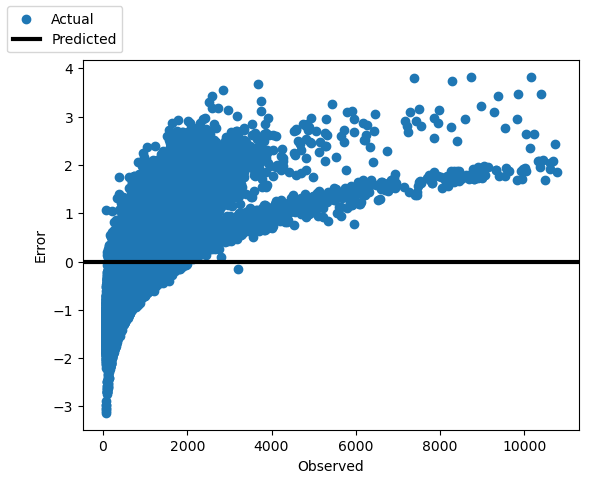

In [49]:
# plot the error difference
error = np.log(y_test) - np.log(y_pred)
fig, ax = plt.subplots()
ax.scatter(y_test, error)
ax.axhline(lw=3, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Error')
fig.legend(labels = ('Actual','Predicted'),loc='upper left')
plt.show()

Text(0.5, 1.0, 'Residual Plot')

<Figure size 640x480 with 0 Axes>

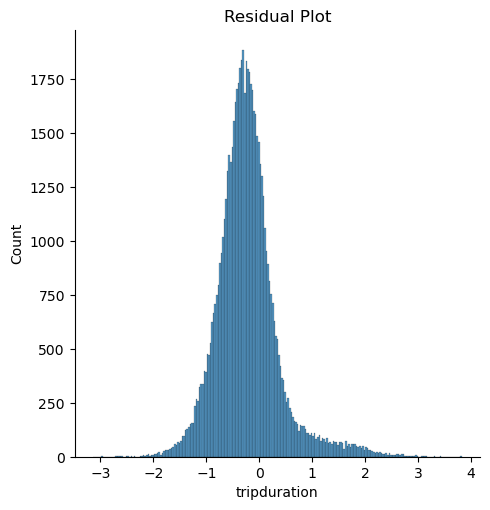

In [50]:
plt.figure()

sns.displot(error)

plt.title("Residual Plot")

In [51]:
#RMSE
print("RMSE is", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 error is " ,r2_score(y_test, y_pred))


RMSE is 586.12103
R2 error is  0.2054367592505696


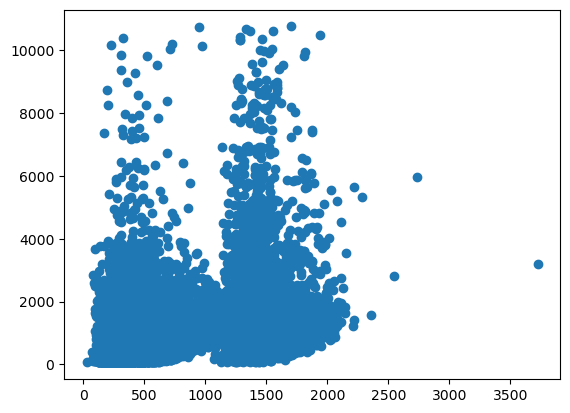

In [72]:
plt.scatter(y_pred, y_test)